In [2]:
import os
import sys
import pickle

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import rioxarray
from osgeo import osr
osr.UseExceptions()

project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))
    
modules_path = 'VITALS\\user_contributed\\modules'
if os.path.join(project_path, modules_path) not in sys.path:
    sys.path.append(join_path(modules_path))
from emit_tools import emit_xarray

In [3]:
emit_002_path = join_path(
    'Data\\Raw_Data\\EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc'
)

emit_003_path = join_path(
    'Data\\Raw_Data\\EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc'
)

emit_002_clean_path = join_path('Data\\Clean_Data\\emit_002.nc')
emit_003_clean_path = join_path('Data\\Clean_Data\\emit_003.nc')

eco_slt_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SLT_20230728T214058_0710_01_LST.tif'
)
eco_slu_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SLU_20230728T214058_0710_01_LST.tif'
)
eco_smt_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SMT_20230728T214058_0710_01_LST.tif'
)
eco_day_path = join_path(
    'Data\\Raw_Data\\ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif'
)
eco_night_path = join_path(
    'Data\\Raw_Data\\ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif'
)

emit_clean_path = join_path('Data\\Clean_Data_2\\emit.nc')

eco_clean_path = join_path('Data\\Clean_Data_2\\ecostress.nc')
eco_day_clean_path = join_path('Data\\Clean_Data_2\\ecostress_day.nc')
eco_night_clean_path = join_path('Data\\Clean_Data_2\\ecostress_night.nc')

emit_yx_path = join_path('Data\\Clean_Data_2\\emit_yx.nc')

eco_on_emit_path = join_path('Data\\Matched_Data_2\\eco_on_emit_yx.nc')
eco_day_on_emit_path = join_path('Data\\Matched_Data_2\\eco_day_on_emit_yx.nc')
eco_night_on_emit_path = join_path(
    'Data\\Matched_Data_2\\eco_night_on_emit_yx.nc'
)

data_yx_path = join_path('Data\\Matched_Data_2\\data_yx.nc')
data_yx_daynight_path = join_path('Data\\Matched_Data_2\\data_yx_daynight.nc')

decomposed_path = join_path('Data\\Decomposed_Data_2\\(__).pkl')
decomposed_daynight_path = join_path(
    'Data\\Decomposed_Data_2\\(__)_daynight.pkl'
)

# Cleaning EMIT datasets

In [4]:
emit_002 = emit_xarray(emit_002_path, ortho=True)
emit_003 = emit_xarray(emit_003_path, ortho=True)

In [ ]:
emit_002 = emit_002.reset_coords('elev')
emit_003 = emit_003.reset_coords('elev')

In [ ]:
for (num_cur, emit_cur) in [('002', emit_002), ('003', emit_003)]:
    # coords
    wavelengths = emit_cur.coords['wavelengths'][
        emit_cur.coords['good_wavelengths'].astype(bool)
    ]
    
    fwhm = emit_cur.coords['fwhm'][
        emit_cur.coords['good_wavelengths'].astype(bool)
    ]

    lat = emit_cur.coords['latitude']
    lon = emit_cur.coords['longitude']
    
    spatial_ref = emit_cur.coords['spatial_ref']
    
    coords ={
        'wavelengths': wavelengths,
        'fwhm': fwhm,
        'latitude': lat,
        'longitude': lon,
        'spatial_ref': spatial_ref,
    }


    # data_vars
    reflectance = np.clip(
        emit_cur.variables['reflectance'][
            :, :, emit_cur.variables['reflectance'].sum(axis=(0,1)) > 0
        ],
        0,
        1,
    )

    elev = emit_cur.variables['elev']

    data_vars = {'reflectance':reflectance, 'elev':elev}


    # build clean dataset
    emit_cur_clean = xr.Dataset(data_vars, coords)
    
    emit_cur_clean = emit_cur_clean.assign_attrs(emit_cur.attrs)

    emit_cur_clean.to_netcdf(
        os.path.join(project_path, f'Data\\Clean_Data\\emit_{num_cur}.nc')
    )

# Combining EMIT datasets

In [3]:
emit_002 = xr.load_dataset(emit_002_clean_path)
emit_003 = xr.load_dataset(emit_003_clean_path)

In [4]:
# coords
wavelengths = emit_002.coords['wavelengths']
fwhm = emit_002.coords['fwhm']
spatial_ref = emit_002.coords['spatial_ref']

lat2 = emit_002.coords['latitude'].values
lat3 = emit_003.coords['latitude'].values
lon2 = emit_002.coords['longitude'].values
lon3 = emit_003.coords['longitude'].values

lat_concat = np.concatenate([lat2, lat3], axis=0)
lon_concat = np.concatenate([lon2, lon3], axis=0)

lat_order = np.argsort(np.argsort(lat_concat))
lon_order = np.argsort(np.argsort(lon_concat))

lat = np.sort(lat_concat)
lon = np.sort(lon_concat)

coords = {
    'wavelengths': wavelengths,
    'fwhm': fwhm,
    'spatial_ref': spatial_ref,
    'latitude': lat,
    'longitude': lon
}

In [5]:
ref2 = emit_002.variables['reflectance'].values
ref3 = emit_003.variables['reflectance'].values

elev2 = emit_002.variables['elev'].values
elev3 = emit_003.variables['elev'].values

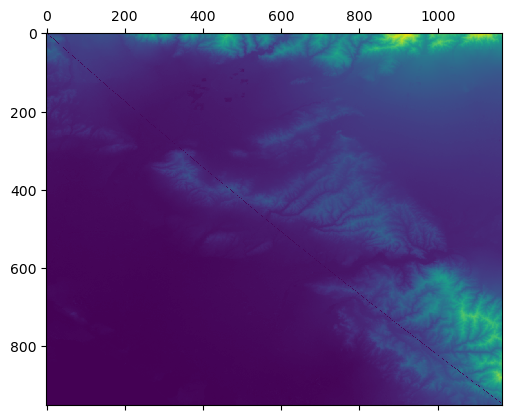

In [21]:
plt.matshow(np.nan_to_num(emit_002.variables['elev'][emit_002.coords['latitude'] > emit_003.coords['latitude'].min(), emit_002.coords['longitude'] > emit_003.coords['longitude'].min()]) + np.nan_to_num(emit_003.variables['elev'][emit_003.coords['latitude'] < emit_002.coords['latitude'].max(), emit_003.coords['longitude'] < emit_002.coords['longitude'].max()]))

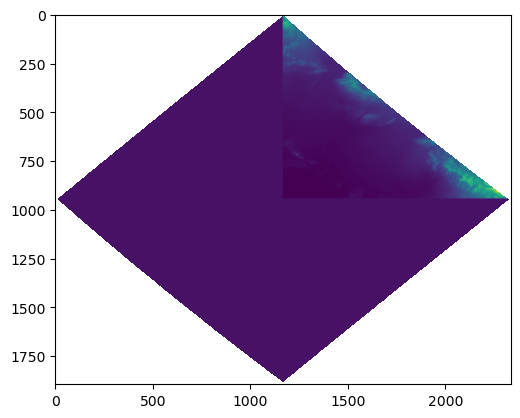

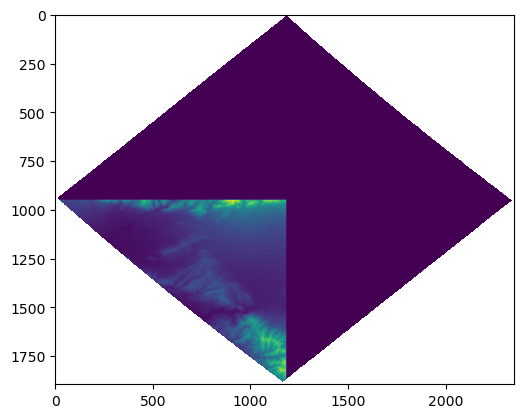

In [23]:
overlap23 = np.meshgrid(
    emit_002.coords['latitude'] > emit_003.coords['latitude'].min(),
    emit_002.coords['longitude'] > emit_003.coords['longitude'].min()
)
overlap32 = np.meshgrid(
    emit_003.coords['latitude'] < emit_002.coords['latitude'].max(),
    emit_003.coords['longitude'] < emit_002.coords['longitude'].max()
)
overlap23 = np.abs(overlap23[0] + overlap23[1] - 1)
overlap32 = np.abs(overlap32[0] + overlap32[1] - 1)
# plt.show(plt.imshow((emit_002.variables['elev'].values * overlap23.T[::-1, ::-1])[:1000, 1100:]))
# plt.show(plt.imshow(emit_002.variables['elev'][:1000, 1100:]))
plt.show(plt.imshow((emit_002.variables['elev'].values * overlap23.T[::-1, ::-1])[:,:]))
plt.show(plt.imshow((emit_003.variables['elev'].values * overlap32.T[::-1, ::-1])[:, :]))


In [6]:
c = 0
num_lon2 = (lon2 > lon3.min()).sum()
for lat2_ind, lat2_val in enumerate(lat2[:(lat2 > lat3.min()).sum()]):
    diff_next = lat2_val - lat2[lat2_ind + 1]
    diff_lat3 = lat2_val - lat3[-(lat3 < lat2.max()).sum():]
    for difF_lat3_val in diff_lat3:
        if difF_lat3_val > 0 and difF_lat3_val < diff_next:
            for lon2_ind, lon2_val in (
                enumerate(lon2[-num_lon2:])
            ):
                diff_prev = lon2_val - lon2[lon2_ind - (num_lon2 + 1)]
                diff_lon3 = lon2_val - lon3[:(lon3 < lon2.max()).sum()]
                for lon3_ind, diff_lon3_val in enumerate(diff_lon3):
                    if diff_lon3_val > 0 and diff_lon3_val < diff_prev:
                        ref2[lat2_ind, lon2_ind - num_lon2, :] = (
                            np.empty(ref2.shape[2]) + np.nan
                        )
                        elev2[lat2_ind, lon2_ind - num_lon2] = np.nan
                        c += 1
    print(lat2_ind, c)

0 1166
1 2332
2 3498
3 4664
4 5830
5 6996
6 8162
7 9328
8 10494
9 11660
10 12826
11 13992
12 15158
13 16324
14 17490
15 18656
16 19822
17 20988
18 22154
19 23320
20 24486
21 25652
22 26818
23 27984
24 29150
25 30316
26 31482
27 32648
28 33814
29 34980
30 36146
31 37312
32 38478
33 39644
34 40810
35 41976
36 43142
37 44308
38 45474
39 46640
40 47806
41 48972
42 50138
43 51304
44 52470
45 53636
46 54802
47 55968
48 57134
49 58300
50 59466
51 60632
52 61798
53 62964
54 64130
55 65296
56 66462
57 67628
58 68794
59 69960
60 71126
61 72292
62 73458
63 74624
64 75790
65 76956
66 78122
67 79288
68 80454
69 81620
70 82786
71 83952
72 85118
73 86284
74 87450
75 88616
76 89782
77 90948
78 92114
79 93280
80 94446
81 95612
82 96778
83 97944
84 99110
85 100276
86 101442
87 102608
88 103774
89 104940
90 106106
91 107272
92 108438
93 109604
94 110770
95 111936
96 113102
97 114268
98 115434
99 116600
100 117766
101 118932
102 120098
103 121264
104 122430
105 123596
106 124762
107 125928
108 127094
109 

In [12]:
len(lat2) / 10 * 2.4 / 60

7.58

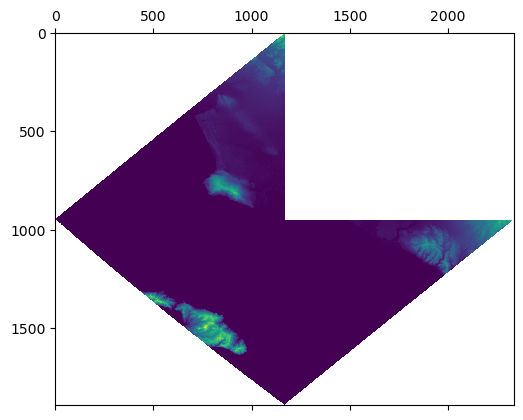

In [7]:
plt.matshow(elev2)

In [8]:
ref = np.empty((len(lat), len(lon), ref2.shape[2])) + np.nan
elev = np.empty((len(lat), len(lon))) + np.nan

for i in range(len(lat2)):
    for j in range(len(lon2)):
        ref[lat_order[i], lon_order[j], :] = ref2[i, j, :]
        elev[lat_order[i], lon_order[j]] = elev2[i, j]

for i in range(len(lat3)):
    for j in range(len(lon3)):
        ref[lat_order[len(lat2) + i], lon_order[len(lon2) + j], :] = (
            ref3[i, j, :]
        )
        elev[lat_order[len(lat2) + i], lon_order[len(lon2) + j]] = elev3[i, j]

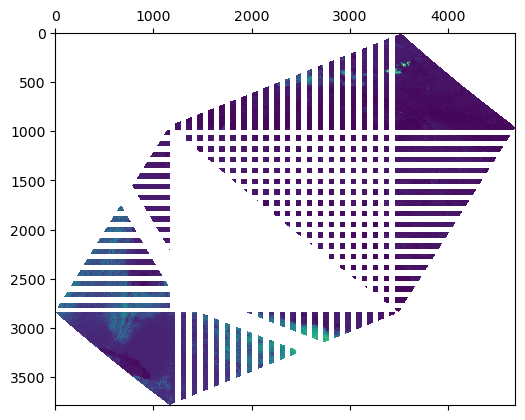

In [9]:
plt.matshow(ref[::-1,:,0])

In [10]:
data_vars = {
    'reflectance':(('latitude', 'longitude', 'wavelengths'), ref),
    'elev':(('latitude', 'longitude'), elev),
}

emit_clean = xr.Dataset(data_vars, coords)

In [11]:
emit_clean = emit_clean.set_coords('elev')
emit_clean['elev'].attrs = {'long_name': 'Surface Elevation', 'units': 'm'}
emit_clean['latitude'].attrs = {
    'long_name': 'Latitude (WGS-84)', 'units': 'degrees north'
}
emit_clean['longitude'].attrs = {
    'long_name': 'Latitude (WGS-84)', 'units': 'degrees east'
}
emit_clean = emit_clean.assign_attrs(emit_002.attrs)

In [12]:
emit_clean.to_netcdf(emit_clean_path)

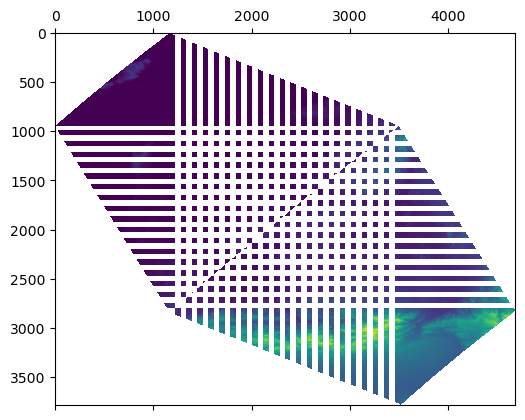

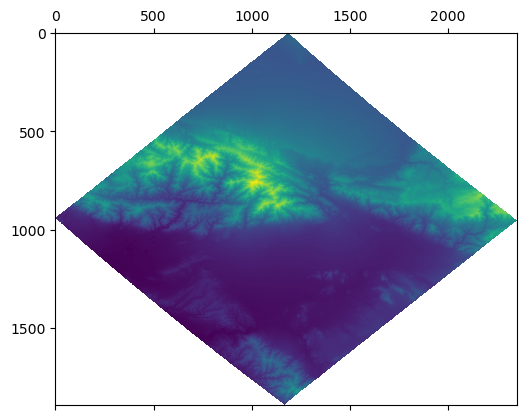

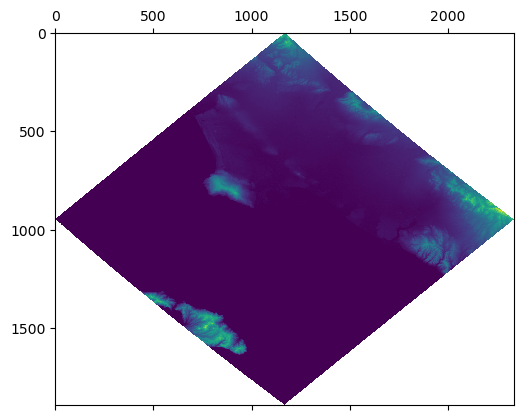

In [25]:
# for visualization

elev = np.empty((len(lat), len(lon))) + np.nan

for i in range(len(lat2)):
    for j in range(len(lon2)):
        elev[lat_order[i], lon_order[j]] = elev2[i, j]

for i in range(len(lat3)):
    for j in range(len(lon3)):
        elev[
            lat_order[len(lat2) + i],
            lon_order[len(lon2) + j]
        ] = elev3[i, j]

plt.show(plt.matshow(elev))
plt.matshow(elev3)
plt.matshow(elev2)

# Combining ECOSTRESS datasets

In [30]:
eco_slt = rioxarray.open_rasterio(eco_slt_path)
eco_slu = rioxarray.open_rasterio(eco_slu_path)
eco_smt = rioxarray.open_rasterio(eco_smt_path)

In [22]:
eco_slt_xr = eco_slt.to_dataset('band').rename({1:'LSTE'})
eco_slu_xr = eco_slu.to_dataset('band').rename({1:'LSTE'})
eco_smt_xr = eco_smt.to_dataset('band').rename({1:'LSTE'})
eco_df = pd.concat(
    [
    eco_slt_xr.to_dataframe(),
    eco_slu_xr.to_dataframe(),
    eco_smt_xr.to_dataframe(),
    ]
)

In [23]:
eco_unique = eco_df.reset_index().drop_duplicates(subset=['y', 'x'])
eco = eco_unique.set_index(['y', 'x']).to_xarray()
eco = eco.assign_attrs(eco_slt.attrs)
eco = eco.reset_coords('spatial_ref', drop=True)
eco = eco.assign_coords({'spatial_ref':eco_slt_xr.variables['spatial_ref']})

In [30]:
eco.to_netcdf(eco_clean_path)

# Aligning EMIT and ECOSTRESS data

In [4]:
eco = xr.open_dataset(
    'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101\\Data\\Raw_Data\\ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif'
)

In [6]:
eco.variables

Frozen({'band': <xarray.IndexVariable 'band' (band: 1)>
array([1]), 'x': <xarray.IndexVariable 'x' (x: 1808)>
array([-118.740314, -118.739683, -118.739052, ..., -117.600951, -117.60032 ,
       -117.599689]), 'y': <xarray.IndexVariable 'y' (y: 1349)>
array([34.350313, 34.349682, 34.349051, ..., 33.500947, 33.500316, 33.499685]), 'spatial_ref': <xarray.Variable ()>
[1 values with dtype=int32]
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTr

In [3]:
# load emit
emit = xr.open_dataset(emit_clean_path)
emit = emit.reset_coords('elev')

# load ecostress
# eco = xr.open_dataset(eco_clean_path)
eco = xr.open_dataset(eco_day_clean_path)

In [4]:
# get the coordinate systems
old_cs = osr.SpatialReference()
old_cs.ImportFromWkt(emit['spatial_ref'].attrs['crs_wkt'])

new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(eco['spatial_ref'].attrs['crs_wkt'])

transform = osr.CoordinateTransformation(old_cs, new_cs)

emit_lat = emit['latitude'].values
emit_lon = emit['longitude'].values

In [5]:
emit_y = np.empty(len(emit_lat)) + np.nan
emit_x = np.empty(len(emit_lon)) + np.nan

for y_ind, lat_val in enumerate(emit_lat):
    emit_y[y_ind] = transform.TransformPoint(
        lat_val,
        emit_lon[int(y_ind / 0.81)],
    )[1]
    
for x_ind, lon_val in enumerate(emit_lon):
    emit_x[x_ind] = transform.TransformPoint(
        emit_lat[int(x_ind * 0.8)],
        lon_val,
    )[0]

(
    (
        np.abs(np.argsort(emit_y) - np.arange(len(emit_y))).sum(),
        np.abs(np.argsort(emit_x) - np.arange(len(emit_x))).sum()
    ),
    (
        len(emit_y) - len(np.unique(emit_y)),
        len(emit_x) - len(np.unique(emit_x)),

    ),
)

((1180, 0), (0, 0))

In [6]:
# coords
wavelengths = emit.coords['wavelengths']
fwhm = emit.coords['fwhm']
spatial_ref = emit.coords['spatial_ref']

y = np.sort(emit_y)
x = np.sort(emit_x)

coords = {
    'wavelengths': wavelengths,
    'fwhm': fwhm,
    'spatial_ref': spatial_ref,
    'y': y,
    'x': x,
}

In [7]:
# variables
ref_old = emit['reflectance'].values
elev_old = emit['elev'].values

y_order = np.argsort(np.argsort(emit_y))
x_order = np.argsort(np.argsort(emit_x))

ref = np.empty_like(ref_old) + np.nan
elev = np.empty_like(elev_old) + np.nan

In [8]:
for i in range(len(y)):
    for j in range(len(x)):
        ref[y_order[i], x_order[j], :] = ref_old[i, j, :]
        elev[y_order[i], x_order[j]] = elev_old[i, j]

data_vars = {
    'reflectance':(('y', 'x', 'wavelengths'), ref),
    'elev':(('y', 'x'), elev),
}

In [9]:
emit_yx = xr.Dataset(data_vars, coords)
emit_yx = emit_yx.assign_attrs(emit.attrs)

In [10]:
emit_yx.to_netcdf(emit_yx_path)

In [3]:
emit_yx = xr.open_dataset(emit_yx_path)

eco = xr.open_dataset(eco_clean_path)

In [4]:
interp_eco = eco.interp_like(emit_yx, assume_sorted=True)

In [5]:
interp_eco.to_netcdf(eco_on_emit_path)

# Processing data

In [6]:
emit_yx = xr.open_dataset(emit_yx_path)
eco_on_emit = xr.open_dataset(eco_on_emit_path)

In [7]:
data_yx = emit_yx.assign({'LSTE': eco_on_emit['LSTE']})

In [8]:
lste = data_yx['LSTE'].values
ref_sum = data_yx['reflectance'].values.sum(axis=2)
elev = data_yx['elev'].values

In [9]:
nan_mask = np.isnan(lste) + np.isnan(ref_sum) + np.isnan(elev)
nan_mask = ~nan_mask.astype(bool)
data_yx = data_yx.assign_coords({'good_coords': (('y', 'x'), nan_mask)})

In [16]:
data_yx.to_netcdf(data_yx_path)

In [17]:
data_yx = xr.open_dataset(data_yx_path)

In [42]:
good_coords = data_yx['good_coords'].values
y_filter = good_coords.sum(axis=1) > 0
x_filter = good_coords.sum(axis=0) > 0
good_coords = good_coords[y_filter, :]
good_coords = good_coords[:, x_filter]

y = data_yx['y'].values[y_filter]
x = data_yx['x'].values[x_filter]

ref = data_yx['reflectance'].values
ref = ref[y_filter, :, :]
ref = ref[:, x_filter, :]

elev = data_yx['elev'].values
elev = elev[y_filter, :]
elev = elev[:, x_filter]

lste = data_yx['LSTE'].values
lste = lste[y_filter, :]
lste = lste[:, x_filter]

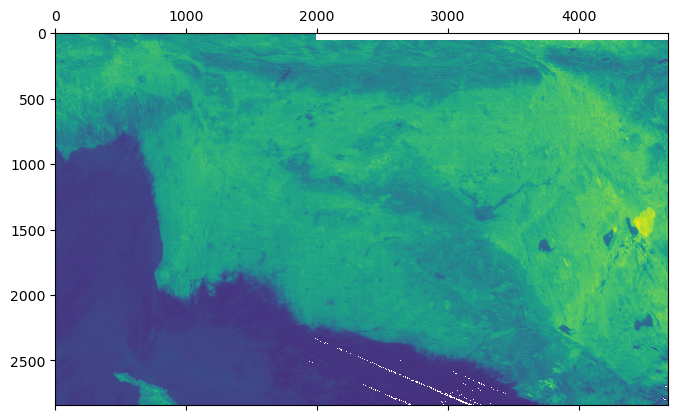

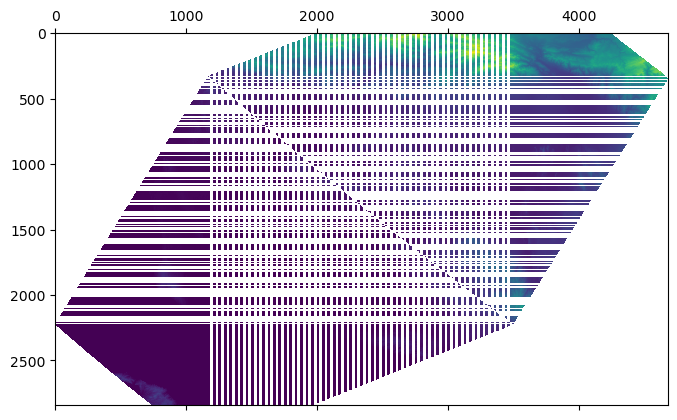

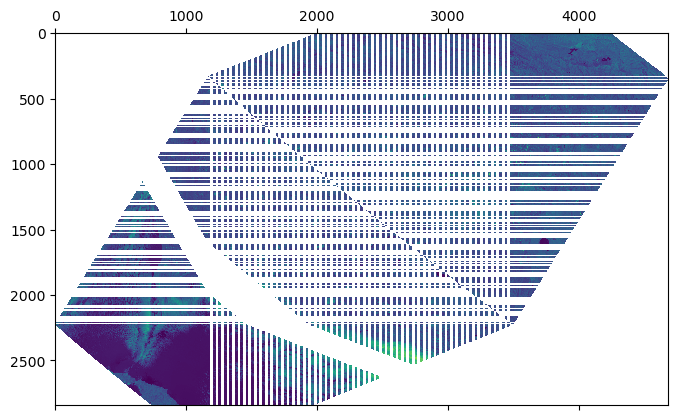

In [43]:
plt.matshow(lste[::-1, :])
plt.matshow(elev[::-1, :])
plt.matshow(ref[::-1, :, 100])

In [44]:
ref_good = ref[good_coords, :]
elev_good = elev[good_coords]
lste_good = lste[good_coords]

In [46]:
pickle_list = [
    ('good_coords', good_coords),
    ('y', y),
    ('x', x),
    ('reflectance', ref),
    ('reflectance_filtered', ref_good),
    ('elevation', elev),
    ('elevation_filtered', elev_good),
    ('LSTE', lste),
    ('LSTE_filtered', lste_good),
]

In [47]:
for filename, data in pickle_list:
    pickle.dump(data, open(decomposed_path.replace('(__)', filename), 'wb'))

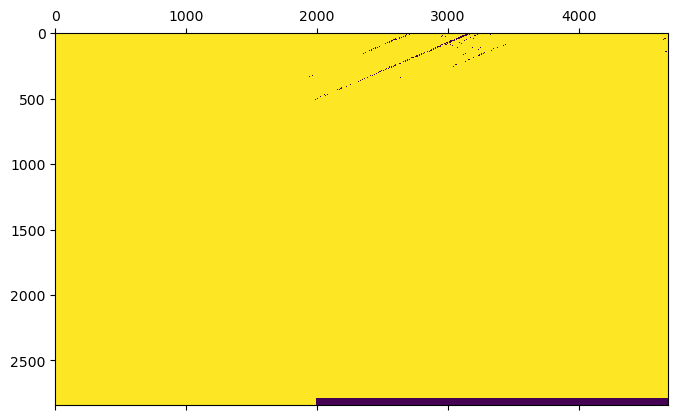

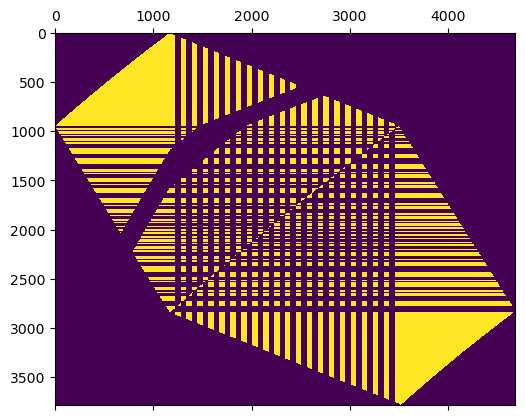

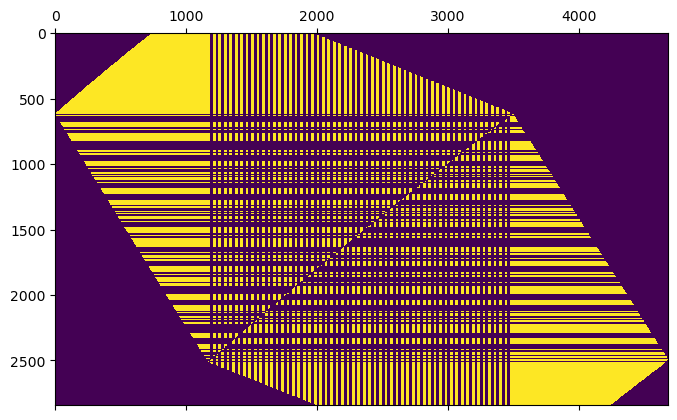

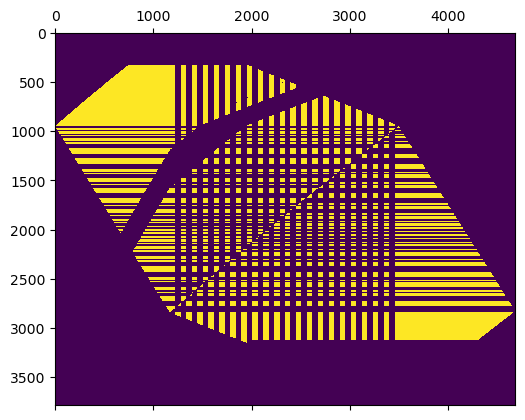

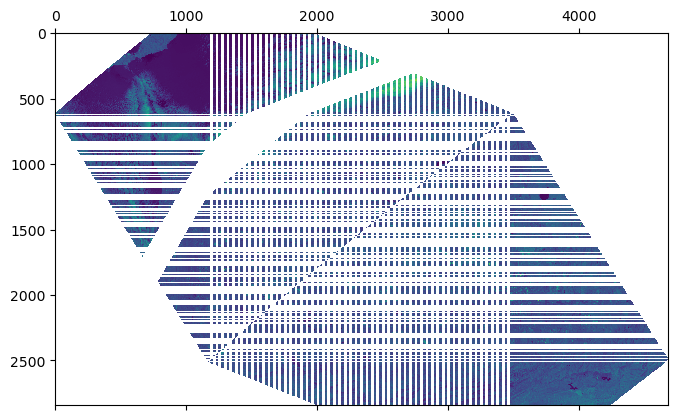

In [48]:
# for visualization
plt.matshow(~np.isnan(lste))
plt.matshow(~np.isnan(ref_sum))
plt.matshow(~np.isnan(elev))
plt.matshow(nan_mask)
plt.matshow(ref[:,:,100])

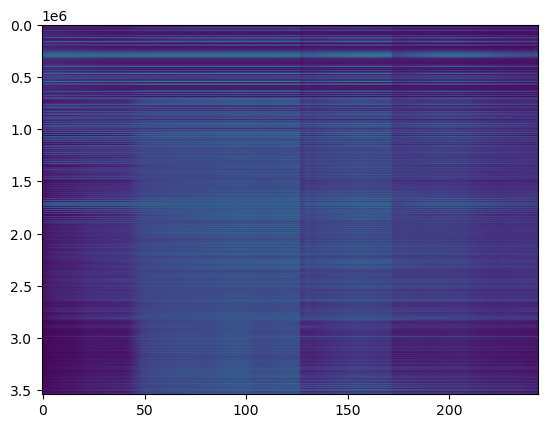

In [51]:
plt.imshow(ref_good, aspect='auto')